# Modeling of PSAT vs SAT demographic predictors of SAT scores

# Import packages & data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline

In [2]:
df_import = pd.read_csv('../data/scores_onehot.csv').drop(['Unnamed: 0'], axis=1, errors='ignore')

In [3]:
df_import.head()

,SAT Math,SAT EBRW,PSAT Math,PSAT EBRW,Median Family Income,Gend_Female,Gend_Male,Ethn_Asian,Ethn_Black,Ethn_Hispanic,Ethn_Two or More Races,Ethn_White,FRL_FRL Eligible,FRL_Not FRL Eligible,ELL_English Learners,ELL_Not English Learners,IEP_Students with IEPs,IEP_Students without IEPs
0,505.882353,560.588235,NaN,NaN,118620.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,537.757009,562.056075,501.909091,535.272727,68454.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,574.725275,564.395604,541.562500,524.583333,68454.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,503.529412,517.058824,NaN,NaN,121412.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,560.444444,579.222222,521.397849,542.580645,121412.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


**Utility functions**

In [4]:
def adj_r2(model, X, y):
    r2 = model.score(X,y)
    n = X.shape[0]
    p = X.shape[1]
    return 1-(1-r2)*(n-1)/(n-p-1)

def print_basic_metrics(model, X, y):
    r_square = model.score(X, y)
    print("R2: {:.4f}".format(r_square))
    r2_adj = adj_r2(model, X, y)
    print("Adj R2: {:.4f}".format(r2_adj))
    return

def print_better_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print("MSE: {:.4f}".format(mse))
    rmse = np.sqrt(mse)
    print("RMSE: {:.4f}".format(rmse))
    mae = mean_absolute_error(y_true, y_pred)
    print("MAE: {:.4f}".format(mae))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print("MAPE: {:.4f}".format(mape))
    return

model_metrics = pd.DataFrame(columns = ['model', 'subject', 'mse', 'rmse', 'mae', 'mape'])

def update_metrics(model, subject, y_true, y_pred):
    global model_metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    #model_metrics = model_metrics.append(pd.Series([model, subject, mse, rmse, mae, mape]), ignore_index=True)
    #model_metrics.loc[model] = [subject, mse, rmse, mae, mape]
    new_metrics = pd.DataFrame({'model':[model],
                                 'subject':[subject],
                                 'mse':[mse],
                                 'rmse':[rmse],
                                 'mae':[mae],
                                 'mape':[mape]})
    model_metrics = pd.concat([model_metrics, new_metrics], ignore_index=True)
    
def plot_feature_importance(model, X_train, X_test, y_test):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(8, 8))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
    plt.title('Feature Importance')
    result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                    random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()
    fig.tight_layout()
    plt.show()
    return

## Pre-processing

In [5]:
# Train/test split

X = df_import.drop(['SAT Math', 'SAT EBRW'], axis=1)
y = df_import[['SAT Math', 'SAT EBRW']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=137)

X_dem_train = X_train.drop(['PSAT Math', 'PSAT EBRW'], axis=1)
y_dem_train = y_train[['SAT Math', 'SAT EBRW']]

X_dem_test = X_test.drop(['PSAT Math', 'PSAT EBRW'], axis=1)
y_dem_test = y_test[['SAT Math', 'SAT EBRW']]

# Rejoin X & y to drop rows missing PSAT scores
psat_train = pd.concat([X_train, y_train], axis=1).dropna()
psat_test = pd.concat([X_test, y_test], axis=1).dropna()

# Split into X & y again
X_psat_train = psat_train[['PSAT Math', 'PSAT EBRW']]
y_psat_train = psat_train[['SAT Math', 'SAT EBRW']]

X_psat_test = psat_test[['PSAT Math', 'PSAT EBRW']]
y_psat_test = psat_test[['SAT Math', 'SAT EBRW']]

In [6]:
scaler_X = StandardScaler()
#Fit & transform training X data
scaler_X.fit(X_dem_train[['Median Family Income']].values)
X_dem_train[['Median Family Income']] = scaler_X.transform(X_dem_train[['Median Family Income']].values)

#Transform training X data
X_dem_test[['Median Family Income']] = scaler_X.transform(X_dem_test[['Median Family Income']].values)

# Models

## PSAT based predictions

### Linear Regression

In [7]:
def linreg_psat_model(x_col, y_col):
    linreg_psat = LinearRegression()
    linreg_psat.fit(X_psat_train[[x_col]], y_psat_train[[y_col]])
    y_tr_pred = linreg_psat.predict(X_psat_train[[x_col]])
    y_te_pred = linreg_psat.predict(X_psat_test[[x_col]])

    print(x_col)
    print('Train')
    print_basic_metrics(linreg_psat, X_psat_train[[x_col]], y_psat_train[[y_col]])
    print('\nTest')
    print_basic_metrics(linreg_psat, X_psat_test[[x_col]], y_psat_test[[y_col]])
    print('\n')

    update_metrics('linreg_psat', x_col, y_psat_test[[y_col]], y_te_pred)
    
    #return y_tr_pred, y_te_pred
    
#psat_tr_pred, psat_te_pred = linreg_psat_model('PSAT Math', 'SAT Math')

linreg_psat_model('PSAT Math', 'SAT Math')
linreg_psat_model('PSAT EBRW', 'SAT EBRW')

model_metrics

PSAT Math
Train
R2: 0.9117
Adj R2: 0.9115

Test
R2: 0.9035
Adj R2: 0.9027


PSAT EBRW
Train
R2: 0.9023
Adj R2: 0.9021

Test
R2: 0.9106
Adj R2: 0.9098




,model,subject,mse,rmse,mae,mape
0,linreg_psat,PSAT Math,308.496700,17.564074,13.318104,0.027065
1,linreg_psat,PSAT EBRW,267.512839,16.355820,12.884870,0.024953


### Gradient boost regression

In [8]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

def gbreg_psat_model(x_col, y_col):
    global gbreg_psat
    gbreg_psat = GradientBoostingRegressor(**params)
    gbreg_psat.fit(X_psat_train[[x_col]], y_psat_train[[y_col]].values.ravel())

    y_te_pred = gbreg_psat.predict(X_psat_test[[x_col]])

    update_metrics('gbreg_psat', x_col, y_psat_test[[y_col]], y_te_pred)
    
gbreg_psat_model('PSAT Math', 'SAT Math')
gbreg_psat_model('PSAT EBRW', 'SAT EBRW')

model_metrics

,model,subject,mse,rmse,mae,mape
0,linreg_psat,PSAT Math,308.496700,17.564074,13.318104,0.027065
1,linreg_psat,PSAT EBRW,267.512839,16.355820,12.884870,0.024953
2,gbreg_psat,PSAT Math,365.235495,19.111135,14.265360,0.028889
3,gbreg_psat,PSAT EBRW,287.494806,16.955672,13.718363,0.026483


In [9]:
#Random Search CV for gradient boost

param_distributions = {
    "n_estimators": range(100,700),
    "max_depth": range(2,10),
    "min_samples_split": range(2,10),
    "learning_rate": [0.001, 0.01, 0.1, 1]
    }

def gb_reg_cv_psat_model(x_col, y_col):
    rscv = RandomizedSearchCV(gbreg_psat, param_distributions, random_state=136,
                                  n_iter = 10)
    search_gbreg_cv_psat = rscv.fit(X_psat_train[[x_col]], y_psat_train[[y_col]].values.ravel())

    gbreg_cv_psat = GradientBoostingRegressor(**search_gbreg_cv_psat.best_params_,  loss= "squared_error")
    gbreg_cv_psat.fit(X_psat_train[[x_col]], y_psat_train[[y_col]].values.ravel())

    y_te_pred = gbreg_cv_psat.predict(X_psat_test[[x_col]])
    
    update_metrics('gbreg_cv_psat', x_col, y_psat_test[[y_col]], y_te_pred)
    
gb_reg_cv_psat_model('PSAT Math', 'SAT Math')
gb_reg_cv_psat_model('PSAT EBRW', 'SAT EBRW')

**Model metrics so far**

In [10]:
model_metrics

,model,subject,mse,rmse,mae,mape
0,linreg_psat,PSAT Math,308.496700,17.564074,13.318104,0.027065
1,linreg_psat,PSAT EBRW,267.512839,16.355820,12.884870,0.024953
2,gbreg_psat,PSAT Math,365.235495,19.111135,14.265360,0.028889
3,gbreg_psat,PSAT EBRW,287.494806,16.955672,13.718363,0.026483
4,gbreg_cv_psat,PSAT Math,469.203411,21.661104,15.381481,0.031379
5,gbreg_cv_psat,PSAT EBRW,319.634505,17.878325,14.443870,0.028164


**Best PSAT based model:  Linear regression**

## Demographic based predictions

### Linear regression

In [11]:
def linreg_dem_model(y_col):
    linreg_dem = LinearRegression()
    linreg_dem.fit(X_dem_train, y_dem_train[[y_col]])
    y_tr_pred = linreg_dem.predict(X_dem_train)
    y_te_pred = linreg_dem.predict(X_dem_test)

    print(y_col)
    print('Train')
    print_basic_metrics(linreg_dem, X_dem_train, y_dem_train[[y_col]])
    print('\nTest')
    print_basic_metrics(linreg_dem, X_dem_test, y_dem_test[[y_col]])
    print('\n')

    update_metrics('linreg_dem', y_col, y_dem_test[[y_col]], y_te_pred)
    
linreg_dem_model('SAT Math')
linreg_dem_model('SAT EBRW')
model_metrics

SAT Math
Train
R2: 0.6867
Adj R2: 0.6786

Test
R2: 0.6757
Adj R2: 0.6394


SAT EBRW
Train
R2: 0.7266
Adj R2: 0.7195

Test
R2: 0.7031
Adj R2: 0.6698




,model,subject,mse,rmse,mae,mape
0,linreg_psat,PSAT Math,308.496700,17.564074,13.318104,0.027065
1,linreg_psat,PSAT EBRW,267.512839,16.355820,12.884870,0.024953
2,gbreg_psat,PSAT Math,365.235495,19.111135,14.265360,0.028889
3,gbreg_psat,PSAT EBRW,287.494806,16.955672,13.718363,0.026483
4,gbreg_cv_psat,PSAT Math,469.203411,21.661104,15.381481,0.031379
5,gbreg_cv_psat,PSAT EBRW,319.634505,17.878325,14.443870,0.028164
6,linreg_dem,SAT Math,1070.220316,32.714222,24.817356,0.048672
7,linreg_dem,SAT EBRW,883.829306,29.729267,23.780954,0.045424


### Gradient boosting regressor

In [12]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

def gbreg_dem_model(y_col):
    X_train = X_dem_train
    X_test = X_dem_test
    y_train = y_dem_train[[y_col]]
    y_test = y_dem_test[[y_col]]
    
    gbreg_dem = GradientBoostingRegressor(**params)
    gbreg_dem.fit(X_train, y_train.values.ravel())

    y_te_pred = gbreg_dem.predict(X_test)

    print('Train')
    print_basic_metrics(gbreg_dem, X_train, y_train)
    print('\nTest')
    print_basic_metrics(gbreg_dem, X_test, y_test)

    update_metrics('gbreg_dem', y_col, y_test, y_te_pred)
    print('\n')
    print_better_metrics(y_test, y_te_pred)

    plot_feature_importance(gbreg_dem, X_train, X_test, y_test)

**SAT Math: Metrics & important features**

Train
R2: 0.8038
Adj R2: 0.7988

Test
R2: 0.6928
Adj R2: 0.6584


MSE: 1013.6018
RMSE: 31.8371
MAE: 23.6339
MAPE: 0.0461


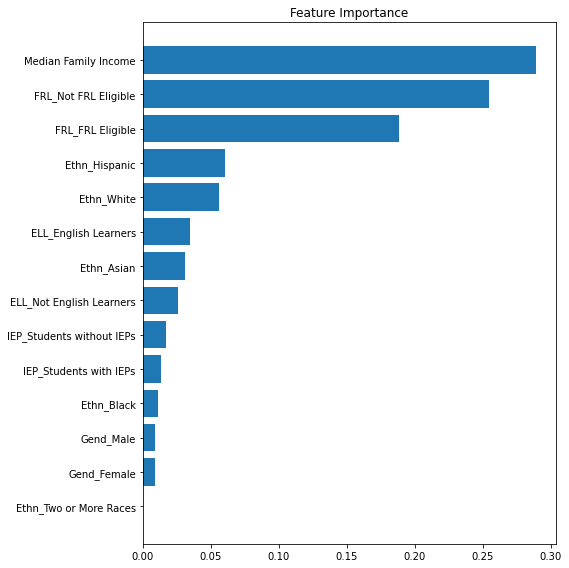

In [13]:
gbreg_dem_model('SAT Math')

**SAT EBRW: Metrics & important features**

Train
R2: 0.8286
Adj R2: 0.8241

Test
R2: 0.7435
Adj R2: 0.7148


MSE: 763.5456
RMSE: 27.6323
MAE: 21.7897
MAPE: 0.0413


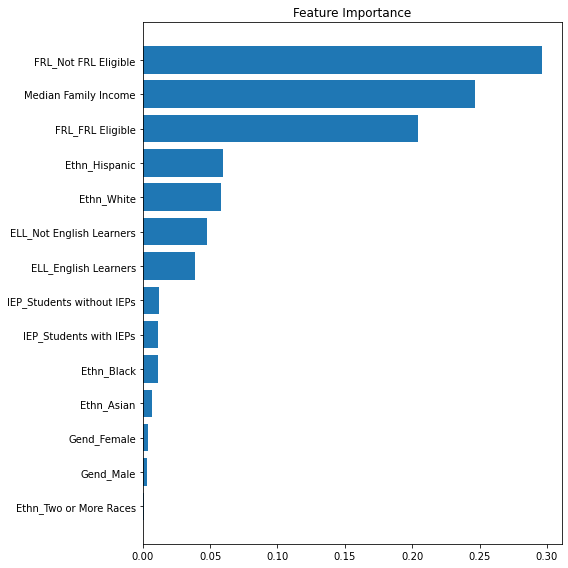

In [14]:
gbreg_dem_model('SAT EBRW')

**Metric summary so far**

In [15]:
model_metrics

,model,subject,mse,rmse,mae,mape
0,linreg_psat,PSAT Math,308.496700,17.564074,13.318104,0.027065
1,linreg_psat,PSAT EBRW,267.512839,16.355820,12.884870,0.024953
2,gbreg_psat,PSAT Math,365.235495,19.111135,14.265360,0.028889
3,gbreg_psat,PSAT EBRW,287.494806,16.955672,13.718363,0.026483
4,gbreg_cv_psat,PSAT Math,469.203411,21.661104,15.381481,0.031379
5,gbreg_cv_psat,PSAT EBRW,319.634505,17.878325,14.443870,0.028164
6,linreg_dem,SAT Math,1070.220316,32.714222,24.817356,0.048672
7,linreg_dem,SAT EBRW,883.829306,29.729267,23.780954,0.045424
8,gbreg_dem,SAT Math,1013.601752,31.837113,23.633867,0.046103
9,gbreg_dem,SAT EBRW,763.545583,27.632329,21.789676,0.041332


## GBReg with cross validation

In [16]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

param_distributions = {
    "n_estimators": range(100,700),
    "max_depth": range(2,10),
    "min_samples_split": range(2,10),
    "learning_rate": [0.001, 0.01, 0.1, 1]
    }

def gbreg_cv_dem_model(y_col):
    X_train = X_dem_train
    X_test = X_dem_test
    y_train = y_dem_train[[y_col]]
    y_test = y_dem_test[[y_col]]
    
    gbreg_dem = GradientBoostingRegressor(**params)
    gbreg_dem.fit(X_train, y_train.values.ravel())
    
    rscv = RandomizedSearchCV(gbreg_dem, param_distributions, random_state=136,
                              n_iter = 20)
    search_gbreg_cv_dem = rscv.fit(X_train, y_train.values.ravel())
    
    gbreg_cv_dem = GradientBoostingRegressor(**search_gbreg_cv_dem.best_params_,  loss= "squared_error")
    gbreg_cv_dem.fit(X_train, y_train.values.ravel())

    y_te_pred = gbreg_cv_dem.predict(X_test)

    print('Train')
    print_basic_metrics(gbreg_cv_dem, X_train, y_train)
    print('\nTest')
    print_basic_metrics(gbreg_cv_dem, X_test, y_test)

    update_metrics('gbreg_cv_dem', y_col, y_test, y_te_pred)
    print('\n')
    print_better_metrics(y_test, y_te_pred)

    plot_feature_importance(gbreg_cv_dem, X_train, X_test, y_test)

**SAT Math: Metrics & important features**

In [ ]:
gbreg_cv_dem_model('SAT Math')

**SAT EBRW: Metrics & important features**

In [ ]:
gbreg_cv_dem_model('SAT EBRW')

**Model summary so far**

In [ ]:
model_metrics

### Random forest regression with random search cv

In [ ]:
# Random Forest Regression with Random Search CV

def rfr_cv_dem_model(y_col):
    X_train = X_dem_train
    X_test = X_dem_test
    y_train = y_dem_train[[y_col]]
    y_test = y_dem_test[[y_col]]

    param_distributions = {
        "n_estimators": range(50,1000),
        "max_depth": range(2,30)
        }

    rfr_dem = RandomForestRegressor()
    rfr_dem.fit(X_train, y_train.values.ravel())

    rscv_rfr_dem = RandomizedSearchCV(rfr_dem, param_distributions, random_state=137,
                                  n_iter = 10)
    search_rfr_dem = rscv_rfr_dem.fit(X_train, y_train.values.ravel())

    rfr_dem = GradientBoostingRegressor(**search_rfr_dem.best_params_,  loss= "squared_error")
    rfr_dem.fit(X_train, y_train.values.ravel())

    y_te_pred = rfr_dem.predict(X_test)

    print('Train')
    print_basic_metrics(rfr_dem, X_train, y_train)
    print('\nTest')
    print_basic_metrics(rfr_dem, X_test, y_test)

    update_metrics('rfr_cv_dem', y_col, y_test, y_te_pred)
    print('\n')
    print_better_metrics(y_test, y_te_pred)

In [ ]:
rfr_cv_dem_model('SAT Math')

In [ ]:
rfr_cv_dem_model('SAT EBRW')

In [ ]:
model_metrics.columns = ['Model', 'Subject', 'MSE', 'RMSE', 'MAE', 'MAPE']

## All model metrics

In [ ]:
model_metrics

### Metrics: PSAT for SAT (Math)

In [ ]:
model_metrics[model_metrics['Subject']=='PSAT Math']

### Metrics: PSAT for SAT (EBRW)

In [ ]:
model_metrics[model_metrics['Subject']=='PSAT EBRW']

### Metrics: Demographics for SAT (Math)

In [ ]:
model_metrics[model_metrics['Subject']=='SAT Math']

### Metrics: Demographics for SAT (EBRW)

In [ ]:
model_metrics[model_metrics['Subject']=='SAT EBRW']

# Best demographic model: Gradient boost regression (with cross validation)

In [ ]:
param_distributions = {
    "n_estimators": range(100,700),
    "max_depth": range(2,10),
    "min_samples_split": range(2,10),
    "learning_rate": [0.001, 0.01, 0.1, 1]
    }

X_train = X_dem_train
X_test = X_dem_test
y_train = y_dem_train[['SAT Math']]
y_test = y_dem_test[['SAT Math']]

gbreg_dem = GradientBoostingRegressor()
gbreg_dem.fit(X_train, y_train.values.ravel())

rscv = RandomizedSearchCV(gbreg_dem, param_distributions, random_state=136,
                          n_iter = 20)
search_gbreg_cv_dem = rscv.fit(X_train, y_train.values.ravel())

gbreg_cv_dem = GradientBoostingRegressor(**search_gbreg_cv_dem.best_params_,  loss= "squared_error")
gbreg_cv_dem.fit(X_train, y_train.values.ravel())

y_te_pred = gbreg_cv_dem.predict(X_test)

In [ ]:
print_basic_metrics(gbreg_cv_dem, X_test, y_test)

In [ ]:
print_better_metrics(y_test, y_te_pred)

In [ ]:
# Best parameters
search_gbreg_cv_dem.best_params_